** Convert waveforms into Mel-scaled power spectrograms **

In [19]:
import os
import re
import time
import librosa
import numpy as np
from scipy import io
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
INPUT_DIRS = [
    '/datasets/kaggle/mls/train_1',
    '/datasets/kaggle/mls/train_2',
    '/datasets/kaggle/mls/train_3',
    '/datasets/kaggle/mls/test_1',
    '/datasets/kaggle/mls/test_2',
    '/datasets/kaggle/mls/test_3'
]

OUTPUT_DIRS = {
    'msgs': 'out/msgs'
}

SAMPLING_RATE = 400
N_CHANNELS = 16
N_SAMPLES = 240000

N_FFT=512
N_MELS=16
DESIRED_MSG_W = 64
HOP_LEN = 1 + int(N_SAMPLES / (DESIRED_MSG_W - 1))

print 'Params:\n'
print 'DESIRED_MSG_W', DESIRED_MSG_W
print 'HOP_LEN', HOP_LEN

Params:

DESIRED_MSG_W 64
HOP_LEN 3810


In [21]:
# make sure output dirs exist
for v in OUTPUT_DIRS.values(): 
    if not os.path.isdir(v): 
        os.makedirs(v)

In [22]:
# list files in directories
def list_files(src_dirs):

    if not list == type(src_dirs): src_dirs = [src_dirs]
    
    f = []
    
    for d in src_dirs:
        df = []
        for (dirpath, dirnames, filenames) in os.walk(d):
            filenames = [dirpath + '/' + x for x in filenames]
            df.extend(filenames)
        f.extend(df)
    
    return f

In [23]:
def read_mat(f):
    mat = io.loadmat(f)
    
    sampling_rate = int(mat['dataStruct'][0, 0][1][0, 0])
    n_samples = int(mat['dataStruct'][0, 0][2][0, 0])
    ch_indexes = np.int8(mat['dataStruct'][0, 0][3][0])
    
    # make sure all files have the same format
    assert(sampling_rate == SAMPLING_RATE)
    assert(n_samples == N_SAMPLES)
    assert(len(ch_indexes) == N_CHANNELS)
    
    data = mat['dataStruct'][0, 0][0].T
    
    waves = np.zeros([len(ch_indexes), n_samples], dtype=np.float32)
    
    for i in range(len(ch_indexes)):
        waves[i] = data[ch_indexes[i] - 1]  
        
    return waves

In [24]:
# compute msg for a wave
def compute_msg(wave, \
                sr=SAMPLING_RATE, hop_length=HOP_LEN, \
                n_fft=N_FFT, n_mels=N_MELS, \
                desired_msg_w=DESIRED_MSG_W):
    
    # pad wave if neccessary to get the desired msg width
    desired_wave_len = hop_length * (desired_msg_w - 1)
    if desired_wave_len > len(wave):
        wave = np.pad(wave, (0, desired_wave_len - len(wave)), \
                      'constant', constant_values=(0))
    
    msg = librosa.feature.melspectrogram(y=wave, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
    msg = librosa.logamplitude(msg ** 2, ref_power=1.)
    
    return msg

In [25]:
# process waveforms
for f in tqdm(list_files(INPUT_DIRS)):
    fid = re.findall(r'([\d_]+)\.mat$', f)[0]
    waves = read_mat(f)
    msgs = np.zeros([N_CHANNELS, N_MELS, DESIRED_MSG_W])
        
    for i in range(waves.shape[0]):
        msgs[i] = compute_msg(waves[i])
        
    msgs_f = OUTPUT_DIRS['msgs'] + '/' + fid + '.npy'
    np.save(msgs_f, np.array(msgs).astype(np.float32))

100%|██████████| 12168/12168 [20:44<00:00,  8.87it/s]


In [26]:
########################################

In [11]:
msgs.shape

(16, 16, 64)

In [12]:
waves = read_mat('/datasets/kaggle/mls/train_2/2_20_0.mat')

In [13]:
msg = compute_msg(waves[0])

(16, 64)


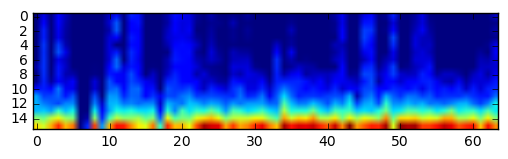

In [17]:
print msg.shape
# plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(msg))
plt.savefig('msg.png')

(96, 1876)


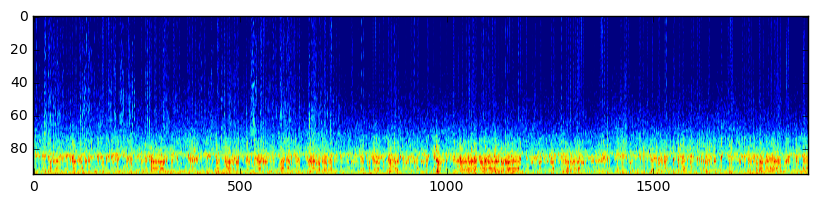

In [17]:
msg = msgs[0]
# msg = np.divide(msg, 255)
print msg.shape
plt.figure(figsize=(10, 3))
plt.imshow(np.flipud(msg), aspect=4)